## The example below takes from the book titled "Apache Spark 2 for Beginners", written by Rajanarayanan Thottuvaikkatumana
## https://github.com/PacktPublishing/Apache-Spark-2-for-Beginners

In [1]:
spark

### Spark UI at http://52.74.103.158:4040/jobs/
### File is stored at /opt/spark-2.3.2 directory

### Chapter 2: The basics of programming with Spark

In [2]:
from decimal import Decimal

In [3]:
acTransList = ["SB10001,1000", "SB10002,1200",
"SB10003,8000", "SB10004,400", "SB10005,300",
"SB10006,10000", "SB10007,500", "SB10008,56",
"SB10009,30","SB10010,7000", "CR10001,7000",
"SB10002,-10"]

In [4]:
acTransRDD = sc.parallelize(acTransList)

In [5]:
goodTransRecords = acTransRDD.filter(lambda trans:Decimal(trans.split(",")[1]) > 0).filter(lambda trans:
                   (trans.split(",")[0]).startswith('SB') == True)

In [6]:
highValueTransRecords = goodTransRecords.filter(lambda trans:Decimal(trans.split(",")[1]) > 1000)

In [7]:
badAmountLambda = lambda trans:Decimal(trans.split(",")[1]) <= 0

In [8]:
badAcNoLambda = lambda trans: (trans.split(",")[0]).startswith('SB') == False

In [9]:
badAmountRecords = acTransRDD.filter(badAmountLambda)

In [10]:
badAccountRecords = acTransRDD.filter(badAcNoLambda)

In [11]:
badTransRecords = badAmountRecords.union(badAccountRecords)

In [12]:
acTransRDD.collect()

['SB10001,1000',
 'SB10002,1200',
 'SB10003,8000',
 'SB10004,400',
 'SB10005,300',
 'SB10006,10000',
 'SB10007,500',
 'SB10008,56',
 'SB10009,30',
 'SB10010,7000',
 'CR10001,7000',
 'SB10002,-10']

In [13]:
goodTransRecords.collect()

['SB10001,1000',
 'SB10002,1200',
 'SB10003,8000',
 'SB10004,400',
 'SB10005,300',
 'SB10006,10000',
 'SB10007,500',
 'SB10008,56',
 'SB10009,30',
 'SB10010,7000']

In [14]:
highValueTransRecords.collect()

['SB10002,1200', 'SB10003,8000', 'SB10006,10000', 'SB10010,7000']

In [15]:
badAccountRecords.collect()

['CR10001,7000']

In [16]:
sumAmounts = goodTransRecords.map(lambda trans:Decimal(trans.split(",")[1])).reduce(lambda a,b : a+b)
sumAmounts

Decimal('28486')

In [17]:
maxAmount = goodTransRecords.map(lambda trans:Decimal(trans.split(",")[1])).reduce(lambda a,b : a if a > b else b)
maxAmount

Decimal('10000')

In [18]:
minAmount = goodTransRecords.map(lambda trans:Decimal(trans.split(",")[1])).reduce(lambda a,b : a if a < b else b)
minAmount

Decimal('30')

In [19]:
combineAllElements = acTransRDD.flatMap(lambda trans: trans.split(","))
combineAllElements.collect()

['SB10001',
 '1000',
 'SB10002',
 '1200',
 'SB10003',
 '8000',
 'SB10004',
 '400',
 'SB10005',
 '300',
 'SB10006',
 '10000',
 'SB10007',
 '500',
 'SB10008',
 '56',
 'SB10009',
 '30',
 'SB10010',
 '7000',
 'CR10001',
 '7000',
 'SB10002',
 '-10']

In [20]:
allGoodAccountNos = combineAllElements.filter(lambda trans:trans.startswith('SB') == True)
allGoodAccountNos.distinct().collect()

['SB10001',
 'SB10003',
 'SB10004',
 'SB10006',
 'SB10008',
 'SB10009',
 'SB10010',
 'SB10002',
 'SB10005',
 'SB10007']

### Chapter 2: MapReduce

In [21]:
acTransList = ["SB10001,1000", "SB10002,1200","SB10001,8000", "SB10002,400", "SB10003,300",
"SB10001,10000", "SB10004,500", "SB10005,56","SB10003,30","SB10002,7000", "SB10001,-100","SB10002,-10"]
acTransRDD = sc.parallelize(acTransList)
acKeyVal = acTransRDD.map(lambda trans:(trans.split(",")[0],Decimal(trans.split(",")[1])))
accSummary = acKeyVal.reduceByKey(lambda a,b : a+b).sortByKey()
accSummary.collect()

[('SB10001', Decimal('18900')),
 ('SB10002', Decimal('8590')),
 ('SB10003', Decimal('330')),
 ('SB10004', Decimal('500')),
 ('SB10005', Decimal('56'))]

### Chapter 2: Joins

In [22]:
acMasterList = ["SB10001,Roger,Federer","SB10002,Pete,Sampras", "SB10003,Rafael,Nadal","SB10004,Boris,Becker", "SB10005,Ivan,Lendl"]
acBalList = ["SB10001,50000", "SB10002,12000","SB10003,3000", "SB10004,8500", "SB10005,5000"]
acMasterRDD = sc.parallelize(acMasterList)
acBalRDD = sc.parallelize(acBalList)
acMasterTuples = acMasterRDD.map(lambda master:master.split(",")).map(lambda masterList:
                            (masterList[0], masterList[1] + " " + masterList[2]))
acBalTuples = acBalRDD.map(lambda trans:trans.split(",")).map(lambda transList: (transList[0],transList[1]))
acJoinTuples = acMasterTuples.join(acBalTuples).sortByKey().map(lambda tran: (tran[0], tran[1][0],tran[1][1]))
acJoinTuples.collect()

[('SB10001', 'Roger Federer', '50000'),
 ('SB10002', 'Pete Sampras', '12000'),
 ('SB10003', 'Rafael Nadal', '3000'),
 ('SB10004', 'Boris Becker', '8500'),
 ('SB10005', 'Ivan Lendl', '5000')]

### Chapter 2: More Actions

In [23]:
acNameAndBalance = acJoinTuples.map(lambda tran:(tran[1],tran[2]))
acTuplesByAmount = acBalTuples.map(lambda tran:(Decimal(tran[1]), tran[0])).sortByKey(False)
acTuplesByAmount.first()

(Decimal('50000'), 'SB10001')

In [24]:
acTuplesByAmount.take(3)

[(Decimal('50000'), 'SB10001'),
 (Decimal('12000'), 'SB10002'),
 (Decimal('8500'), 'SB10004')]

In [25]:
acBalTuples.countByKey()

defaultdict(int,
            {'SB10001': 1,
             'SB10002': 1,
             'SB10003': 1,
             'SB10004': 1,
             'SB10005': 1})

In [26]:
acBalTuples.count()

5

In [27]:
acNameAndBalance.foreach(print)
('Pete Sampras', '12000')
('Roger Federer', '50000')
('Rafael Nadal', '3000')
('Boris Becker', '8500')
('Ivan Lendl', '5000')

('Ivan Lendl', '5000')

In [28]:
balanceTotal = sc.accumulator(0.0)
balanceTotal.value

0.0

In [29]:
acBalTuples.foreach(lambda bals:balanceTotal.add(float(bals[1])))
balanceTotal.value

78500.0

### Chapter 3: Spark SQL

In [30]:
from pyspark.sql import Row
# Creation of the list from where the RDD is going to be created
acTransList = ["SB10001,1000", "SB10002,1200","SB10003,8000", "SB10004,400", "SB10005,300",
               "SB10006,10000", "SB10007,500", "SB10008,56","SB10009,30","SB10010,7000", "CR10001,7000","SB10002,-10"]
# Create the DataFrame
acTransDF = sc.parallelize(acTransList).map(lambda trans: trans.split(",")).map(lambda p: Row(accNo=p[0],tranAmount=float(p[1]))).toDF()
# Register temporary view in the DataFrame for using it in SQL
acTransDF.createOrReplaceTempView("trans")
# Print the structure of the DataFrame
acTransDF.printSchema()
# Show the first few records of the DataFrame
acTransDF.show()

root
 |-- accNo: string (nullable = true)
 |-- tranAmount: double (nullable = true)

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|SB10001|    1000.0|
|SB10002|    1200.0|
|SB10003|    8000.0|
|SB10004|     400.0|
|SB10005|     300.0|
|SB10006|   10000.0|
|SB10007|     500.0|
|SB10008|      56.0|
|SB10009|      30.0|
|SB10010|    7000.0|
|CR10001|    7000.0|
|SB10002|     -10.0|
+-------+----------+



In [31]:
# Use SQL to create another DataFrame containing the good transaction records
goodTransRecords = spark.sql("SELECT accNo, tranAmount FROM trans WHERE accNo like 'SB%' AND tranAmount > 0")
# Register temporary table in the DataFrame for using it in SQL
goodTransRecords.createOrReplaceTempView("goodtrans")
# Show the first few records of the DataFrame
goodTransRecords.show()

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|SB10001|    1000.0|
|SB10002|    1200.0|
|SB10003|    8000.0|
|SB10004|     400.0|
|SB10005|     300.0|
|SB10006|   10000.0|
|SB10007|     500.0|
|SB10008|      56.0|
|SB10009|      30.0|
|SB10010|    7000.0|
+-------+----------+



In [32]:
# Use SQL to create another DataFrame containing the high value transaction records
highValueTransRecords = spark.sql("SELECT accNo, tranAmount FROM goodtrans WHERE tranAmount > 1000")
# Show the first few records of the DataFrame
highValueTransRecords.show()

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|SB10002|    1200.0|
|SB10003|    8000.0|
|SB10006|   10000.0|
|SB10010|    7000.0|
+-------+----------+



In [33]:
# Use SQL to create another DataFrame containing the bad account records
badAccountRecords = spark.sql("SELECT accNo, tranAmount FROM trans WHERE accNo NOT like 'SB%'")
# Show the first few records of the DataFrame
badAccountRecords.show()

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|CR10001|    7000.0|
+-------+----------+



In [34]:
# Use SQL to create another DataFrame containing the bad amount records
badAmountRecords = spark.sql("SELECT accNo, tranAmount FROM trans WHERE tranAmount < 0")
# Show the first few records of the DataFrame
badAmountRecords.show()

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|SB10002|     -10.0|
+-------+----------+



In [35]:
# Do the union of two DataFrames and create another DataFrame
badTransRecords = badAccountRecords.union(badAmountRecords)
# Show the first few records of the DataFrame
badTransRecords.show()

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|CR10001|    7000.0|
|SB10002|     -10.0|
+-------+----------+



In [36]:
# Calculate the sum
sumAmount = spark.sql("SELECT sum(tranAmount)as sum FROM goodtrans")
# Show the first few records of the DataFrame
sumAmount.show()

+-------+
|    sum|
+-------+
|28486.0|
+-------+



In [37]:
# Calculate the sum
sumAmount = goodTransRecords.agg({"tranAmount":"sum"})
# Show the first few records of the DataFrame
sumAmount.show()

+---------------+
|sum(tranAmount)|
+---------------+
|        28486.0|
+---------------+



In [38]:
# Calculate the maximum
maxAmount = spark.sql("SELECT max(tranAmount) as max FROM goodtrans")
# Show the first few records of the DataFrame
maxAmount.show()

+-------+
|    max|
+-------+
|10000.0|
+-------+



In [39]:
# Calculate the maximum
maxAmount = goodTransRecords.agg({"tranAmount":"max"})
# Show the first few records of the DataFrame
maxAmount.show()

+---------------+
|max(tranAmount)|
+---------------+
|        10000.0|
+---------------+



In [40]:
# Calculate the minimum
minAmount = spark.sql("SELECT min(tranAmount)as min FROM goodtrans")
# Show the first few records of the DataFrame
minAmount.show()

+----+
| min|
+----+
|30.0|
+----+



In [41]:
# Calculate the minimum
minAmount = goodTransRecords.agg({"tranAmount":"min"})
# Show the first few records of the DataFrame
minAmount.show()

+---------------+
|min(tranAmount)|
+---------------+
|           30.0|
+---------------+



In [42]:
# Use SQL to create another DataFrame containing the good account numbers
goodAccNos = spark.sql("SELECT DISTINCT accNo FROM trans WHERE accNo like 'SB%' ORDER BY accNo")
# Show the first few records of the DataFrame
goodAccNos.show()

+-------+
|  accNo|
+-------+
|SB10001|
|SB10002|
|SB10003|
|SB10004|
|SB10005|
|SB10006|
|SB10007|
|SB10008|
|SB10009|
|SB10010|
+-------+



In [43]:
# Create the DataFrame using API for the good account numbers
goodAccNos = acTransDF.filter("accNo like 'SB%'").select("accNo").distinct().orderBy("accNo")
# Show the first few records of the DataFrame
goodAccNos.show()

+-------+
|  accNo|
+-------+
|SB10001|
|SB10002|
|SB10003|
|SB10004|
|SB10005|
|SB10006|
|SB10007|
|SB10008|
|SB10009|
|SB10010|
+-------+



In [44]:
# Calculate the sum using mixing of DataFrame and RDD like operations
sumAmountByMixing = goodTransRecords.rdd.map(lambda trans:trans.tranAmount).reduce(lambda a,b : a+b)
sumAmountByMixing

28486.0

In [45]:
# Calculate the maximum using mixing of DataFrame and RDD like operations
maxAmountByMixing = goodTransRecords.rdd.map(lambda trans:trans.tranAmount).reduce(lambda a,b : a if a > b else b)
maxAmountByMixing

10000.0

In [46]:
# Calculate the minimum using mixing of DataFrame and RDD like operations
minAmountByMixing = goodTransRecords.rdd.map(lambda trans:trans.tranAmount).reduce(lambda a,b : a if a < b else b)
minAmountByMixing

30.0

In [47]:
# Persist the data of the DataFrame into a Parquet file
acTransDF.write.parquet("python.trans.parquet")
# Read the data into a DataFrame from the Parquet file
acTransDFfromParquet = spark.read.parquet("python.trans.parquet")
# Show the first few records of the DataFrame
acTransDFfromParquet.show()

+-------+----------+
|  accNo|tranAmount|
+-------+----------+
|SB10007|     500.0|
|SB10008|      56.0|
|SB10009|      30.0|
|SB10010|    7000.0|
|CR10001|    7000.0|
|SB10002|     -10.0|
|SB10001|    1000.0|
|SB10002|    1200.0|
|SB10003|    8000.0|
|SB10004|     400.0|
|SB10005|     300.0|
|SB10006|   10000.0|
+-------+----------+



### Chapter 3: Understanding Aggregations in Spark SQL

In [48]:
from pyspark.sql import Row
# Creation of the list from where the RDD is going to be created
acTransList = ["SB10001,1000", "SB10002,1200","SB10001,8000","SB10002,400", "SB10003,300",
               "SB10001,10000","SB10004,500","SB10005,56","SB10003,30","SB10002,7000", "SB10001,-100","SB10002,-10"]
# Create the DataFrame
acTransDF = sc.parallelize(acTransList).map(lambda trans: trans.split(",")).map(lambda p: Row(accNo=p[0],tranAmount=float(p[1]))).toDF()
# Register temporary view in the DataFrame for using it in SQL
acTransDF.createOrReplaceTempView("trans")
# Use SQL to create another DataFrame containing the account summary records
acSummary = spark.sql("SELECT accNo, sum(tranAmount) as transTotal FROM trans GROUP BY accNo")
# Show the first few records of the DataFrame
acSummary.show()

+-------+----------+
|  accNo|transTotal|
+-------+----------+
|SB10005|      56.0|
|SB10004|     500.0|
|SB10003|     330.0|
|SB10002|    8590.0|
|SB10001|   18900.0|
+-------+----------+



In [49]:
# Create the DataFrame using API for the account summary records
acSummaryViaDFAPI = acTransDF.groupBy("accNo").agg({"tranAmount":"sum"}).selectExpr("accNo", "`sum(tranAmount)` as transTotal")
# Show the first few records of the DataFrame
acSummaryViaDFAPI.show()

+-------+----------+
|  accNo|transTotal|
+-------+----------+
|SB10005|      56.0|
|SB10004|     500.0|
|SB10003|     330.0|
|SB10002|    8590.0|
|SB10001|   18900.0|
+-------+----------+



### Chapter 3: Understanding multi-datasource joining with SparkSQL

In [50]:
from pyspark.sql import Row
# Creation of the list from where the RDD is going to be created
AcMaster = Row('accNo', 'firstName', 'lastName')
AcBal = Row('accNo', 'balanceAmount')
acMasterList = ["SB10001,Roger,Federer","SB10002,Pete,Sampras","SB10003,Rafael,Nadal","SB10004,Boris,Becker",
                "SB10005,Ivan,Lendl"]
acBalList = ["SB10001,50000","SB10002,12000","SB10003,3000", "SB10004,8500","SB10005,5000"]
# Create the DataFrame
acMasterDF = sc.parallelize(acMasterList).map(lambda trans:trans.split(",")).map(lambda r: AcMaster(*r)).toDF()
acBalDF = sc.parallelize(acBalList).map(lambda trans: trans.split(",")).map(lambda r: AcBal(r[0],float(r[1]))).toDF()
# Persist the data of the DataFrame into a Parquet file
acMasterDF.write.parquet("python.master.parquet")
# Persist the data of the DataFrame into a JSON file
acBalDF.write.json("pythonMaster.json")
# Read the data into a DataFrame from the Parquet file
acMasterDFFromFile = spark.read.parquet("python.master.parquet")
# Register temporary table in the DataFrame for using it in SQL
acMasterDFFromFile.createOrReplaceTempView("master")
# Register temporary table in the DataFrame for using it in SQL
acBalDFFromFile = spark.read.json("pythonMaster.json")
# Register temporary table in the DataFrame for using it in SQL
acBalDFFromFile.createOrReplaceTempView("balance")
# Show the first few records of the DataFrame
acMasterDFFromFile.show()

+-------+---------+--------+
|  accNo|firstName|lastName|
+-------+---------+--------+
|SB10003|   Rafael|   Nadal|
|SB10004|    Boris|  Becker|
|SB10005|     Ivan|   Lendl|
|SB10001|    Roger| Federer|
|SB10002|     Pete| Sampras|
+-------+---------+--------+



In [51]:
# Show the first few records of the DataFrame
acBalDFFromFile.show()

+-------+-------------+
|  accNo|balanceAmount|
+-------+-------------+
|SB10003|       3000.0|
|SB10004|       8500.0|
|SB10005|       5000.0|
|SB10001|      50000.0|
|SB10002|      12000.0|
+-------+-------------+



In [52]:
# Use SQL to create another DataFrame containing the account detail records
acDetail = spark.sql("SELECT master.accNo,firstName, lastName, balanceAmount FROM master,balance WHERE master.accNo = balance.accNo ORDER BY balanceAmount DESC")
# Show the first few records of the DataFrame
acDetail.show()

+-------+---------+--------+-------------+
|  accNo|firstName|lastName|balanceAmount|
+-------+---------+--------+-------------+
|SB10001|    Roger| Federer|      50000.0|
|SB10002|     Pete| Sampras|      12000.0|
|SB10004|    Boris|  Becker|       8500.0|
|SB10005|     Ivan|   Lendl|       5000.0|
|SB10003|   Rafael|   Nadal|       3000.0|
+-------+---------+--------+-------------+



In [53]:
# Create the DataFrame using API for the account detail records
acDetailFromAPI = acMasterDFFromFile.join(acBalDFFromFile,acMasterDFFromFile.accNo ==acBalDFFromFile.accNo).sort(acBalDFFromFile.balanceAmount, ascending=False).select(acMasterDFFromFile.accNo,
                  acMasterDFFromFile.firstName,acMasterDFFromFile.lastName,acBalDFFromFile.balanceAmount)
# Show the first few records of the DataFrame
acDetailFromAPI.show()

+-------+---------+--------+-------------+
|  accNo|firstName|lastName|balanceAmount|
+-------+---------+--------+-------------+
|SB10001|    Roger| Federer|      50000.0|
|SB10002|     Pete| Sampras|      12000.0|
|SB10004|    Boris|  Becker|       8500.0|
|SB10005|     Ivan|   Lendl|       5000.0|
|SB10003|   Rafael|   Nadal|       3000.0|
+-------+---------+--------+-------------+



In [54]:
# Use SQL to create another DataFrame containing the top 3 account detail records
acDetailTop3 = spark.sql("SELECT master.accNo,firstName, lastName, balanceAmount FROM master,balance WHERE master.accNo = balance.accNo ORDER BY balanceAmount DESC").limit(3)
# Show the first few records of the DataFrame
acDetailTop3.show()

+-------+---------+--------+-------------+
|  accNo|firstName|lastName|balanceAmount|
+-------+---------+--------+-------------+
|SB10001|    Roger| Federer|      50000.0|
|SB10002|     Pete| Sampras|      12000.0|
|SB10004|    Boris|  Becker|       8500.0|
+-------+---------+--------+-------------+



### Chapter 5: Spark Data Analysis with Python

In [55]:
# Import all the required libraries
from pyspark.sql import Row
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
plt.rcdefaults()
# TODO - The following location has to be changed to the appropriate data file location
dataDir = "/home/thiamhuat/data/ml-100k/"
# Create the DataFrame of the user dataset
lines = sc.textFile(dataDir + "u.user")
splitLines = lines.map(lambda l: l.split("|"))
usersRDD = splitLines.map(lambda p: Row(id=p[0],age=int(p[1]), gender=p[2], occupation=p[3],zipcode=p[4]))
usersDF = spark.createDataFrame(usersRDD)
usersDF.createOrReplaceTempView("users")
usersDF.show()

+---+------+---+-------------+-------+
|age|gender| id|   occupation|zipcode|
+---+------+---+-------------+-------+
| 24|     M|  1|   technician|  85711|
| 53|     F|  2|        other|  94043|
| 23|     M|  3|       writer|  32067|
| 24|     M|  4|   technician|  43537|
| 33|     F|  5|        other|  15213|
| 42|     M|  6|    executive|  98101|
| 57|     M|  7|administrator|  91344|
| 36|     M|  8|administrator|  05201|
| 29|     M|  9|      student|  01002|
| 53|     M| 10|       lawyer|  90703|
| 39|     F| 11|        other|  30329|
| 28|     F| 12|        other|  06405|
| 47|     M| 13|     educator|  29206|
| 45|     M| 14|    scientist|  55106|
| 49|     F| 15|     educator|  97301|
| 21|     M| 16|entertainment|  10309|
| 30|     M| 17|   programmer|  06355|
| 35|     F| 18|        other|  37212|
| 40|     M| 19|    librarian|  02138|
| 42|     F| 20|    homemaker|  95660|
+---+------+---+-------------+-------+
only showing top 20 rows



In [56]:
# Create the DataFrame of the user dataset with only one column age
ageDF = spark.sql("SELECT age FROM users")
ageList = ageDF.rdd.map(lambda p:p.age).collect()
ageDF.describe().show()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              943|
|   mean|34.05196182396607|
| stddev|12.19273973305903|
|    min|                7|
|    max|               73|
+-------+-----------------+



### Histogram

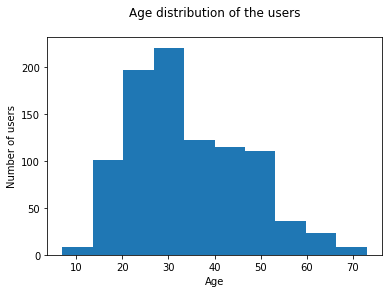

In [57]:
# Age distribution of the users
plt.hist(ageList)
plt.title("Age distribution of the users\n")
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.show(block=False)

### Density plot

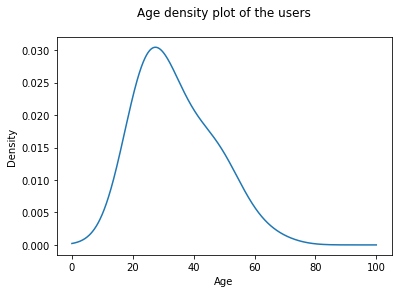

In [58]:
# Draw a density plot
from scipy.stats import gaussian_kde
density = gaussian_kde(ageList)
xAxisValues = np.linspace(0,100,1000)
density.covariance_factor = lambda : .5
density._compute_covariance()
plt.title("Age density plot of the users\n")
plt.xlabel("Age")
plt.ylabel("Density")
plt.plot(xAxisValues, density(xAxisValues))
plt.show(block=False)

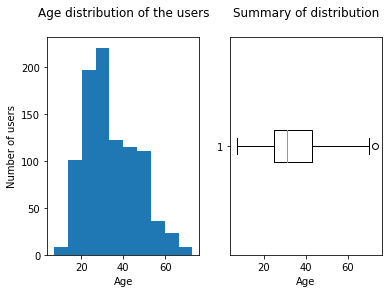

In [59]:
# The following example demonstrates the creation of multiple diagrams in one figure
# There are two plots on one row
# The first one is the histogram of the distribution
# The second one is the boxplot containing the summary of the distribution
plt.subplot(121)
plt.hist(ageList)
plt.title("Age distribution of the users\n")
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.subplot(122)
plt.title("Summary of distribution\n")
plt.xlabel("Age")
plt.boxplot(ageList, vert=False)
plt.show(block=False)

In [60]:
occupationsTop10 = spark.sql("SELECT occupation,count(occupation) as usercount FROM users GROUP BY occupation ORDER BY usercount DESC LIMIT 10")
occupationsTop10.show()

+-------------+---------+
|   occupation|usercount|
+-------------+---------+
|      student|      196|
|        other|      105|
|     educator|       95|
|administrator|       79|
|     engineer|       67|
|   programmer|       66|
|    librarian|       51|
|       writer|       45|
|    executive|       32|
|    scientist|       31|
+-------------+---------+



### Bar chart

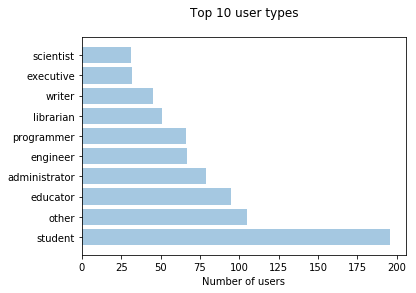

In [61]:
occupationsTop10Tuple = occupationsTop10.rdd.map(lambda p:(p.occupation,p.usercount)).collect()
occupationsTop10List, countTop10List = zip(*occupationsTop10Tuple)
occupationsTop10Tuple
# Top 10 occupations in terms of the number of users having that occupation who have rated movies
y_pos = np.arange(len(occupationsTop10List))
plt.barh(y_pos, countTop10List, align='center', alpha=0.4)
plt.yticks(y_pos, occupationsTop10List)
plt.xlabel('Number of users')
plt.title('Top 10 user types\n')
plt.gcf().subplots_adjust(left=0.15)
plt.show(block=False)

In [62]:
occupationsGender = spark.sql("SELECT occupation,gender FROM users")
occupationsGender.show()

+-------------+------+
|   occupation|gender|
+-------------+------+
|   technician|     M|
|        other|     F|
|       writer|     M|
|   technician|     M|
|        other|     F|
|    executive|     M|
|administrator|     M|
|administrator|     M|
|      student|     M|
|       lawyer|     M|
|        other|     F|
|        other|     F|
|     educator|     M|
|    scientist|     M|
|     educator|     F|
|entertainment|     M|
|   programmer|     M|
|        other|     F|
|    librarian|     M|
|    homemaker|     F|
+-------------+------+
only showing top 20 rows



In [63]:
occCrossTab = occupationsGender.stat.crosstab("occupation","gender")
occCrossTab.show()

+-----------------+---+---+
|occupation_gender|  F|  M|
+-----------------+---+---+
|        scientist|  3| 28|
|          student| 60|136|
|           writer| 19| 26|
|         salesman|  3|  9|
|          retired|  1| 13|
|    administrator| 36| 43|
|       programmer|  6| 60|
|           doctor|  0|  7|
|        homemaker|  6|  1|
|        executive|  3| 29|
|         engineer|  2| 65|
|    entertainment|  2| 16|
|        marketing| 10| 16|
|       technician|  1| 26|
|           artist| 13| 15|
|        librarian| 29| 22|
|           lawyer|  2| 10|
|         educator| 26| 69|
|       healthcare| 11|  5|
|             none|  4|  5|
+-----------------+---+---+
only showing top 20 rows



### Stacked bar chart

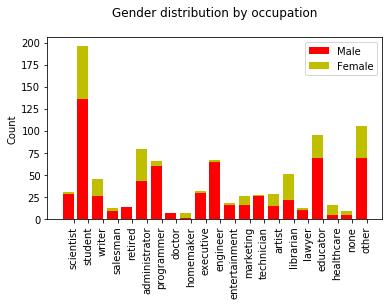

In [64]:
occupationsCrossTuple = occCrossTab.rdd.map(lambda p:(p.occupation_gender,p.M, p.F)).collect()
occList, mList, fList = zip(*occupationsCrossTuple)
N = len(occList)
ind = np.arange(N) # the x locations for the groups
width = 0.75 # the width of the bars 
p1 = plt.bar(ind, mList, width, color='r')
p2 = plt.bar(ind, fList, width, color='y', bottom=mList)
plt.ylabel('Count')
plt.title('Gender distribution by occupation\n')
plt.xticks(ind + width/2., occList, rotation=90)
plt.legend((p1[0], p2[0]), ('Male', 'Female'))
plt.gcf().subplots_adjust(bottom=0.25)
plt.show(block=False)

In [65]:
 occCrossTab.describe('M', 'F').show()

+-------+------------------+------------------+
|summary|                 M|                 F|
+-------+------------------+------------------+
|  count|                21|                21|
|   mean|31.904761904761905|              13.0|
| stddev|  32.3757698934014|15.874507866387544|
|    min|                 1|                 0|
|    max|               136|                60|
+-------+------------------+------------------+



In [66]:
occupationsBottom10 = spark.sql("SELECT occupation, count(occupation) as usercount FROM users GROUP BY occupation ORDER BY usercount LIMIT 10")
occupationsBottom10.show()

+-------------+---------+
|   occupation|usercount|
+-------------+---------+
|       doctor|        7|
|    homemaker|        7|
|         none|        9|
|     salesman|       12|
|       lawyer|       12|
|      retired|       14|
|   healthcare|       16|
|entertainment|       18|
|    marketing|       26|
|   technician|       27|
+-------------+---------+



### Pie chart

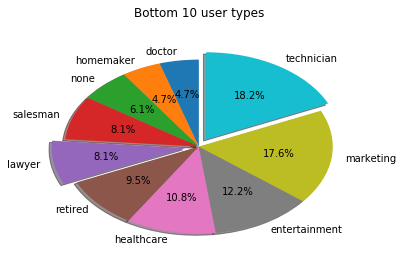

In [67]:
occupationsBottom10Tuple = occupationsBottom10.rdd.map(lambda p:(p.occupation,p.usercount)).collect()
occupationsBottom10List, countBottom10List = zip(*occupationsBottom10Tuple)
# Bottom 10 occupations in terms of the number of users having that occupation who have rated movies
explode = (0, 0, 0, 0,0.1,0,0,0,0,0.1)
plt.pie(countBottom10List,explode=explode, labels=occupationsBottom10List,autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Bottom 10 user types\n')
plt.show(block=False)

In [68]:
zipTop10 = spark.sql("SELECT zipcode,count(zipcode) as usercount FROM users GROUP BY zipcode ORDER BY usercount DESC LIMIT 10")
zipTop10.show()

+-------+---------+
|zipcode|usercount|
+-------+---------+
|  55414|        9|
|  55105|        6|
|  20009|        5|
|  10003|        5|
|  55337|        5|
|  27514|        4|
|  55408|        4|
|  55454|        4|
|  94043|        3|
|  55106|        3|
+-------+---------+



### Donut chart

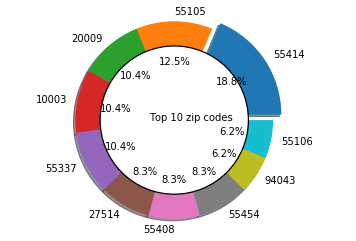

In [69]:
zipTop10Tuple = zipTop10.rdd.map(lambda p:(p.zipcode,p.usercount)).collect()
zipTop10List, countTop10List = zip(*zipTop10Tuple)
# Top 10 zipcodes in terms of the number of users living in that zipcode who have rated movies
explode = (0.1, 0, 0, 0,0,0,0,0,0,0) # explode a slice if required
plt.pie(countTop10List, explode=explode,labels=zipTop10List, autopct='%1.1f%%', shadow=True)
#Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black',fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# The aspect ratio is to be made equal.This is to make sure that pie chart is coming perfectly as a circle.
plt.axis('equal')
plt.text(- 0.25,0,'Top 10 zip codes')
plt.show(block=False)

In [70]:
ages = spark.sql("SELECT occupation, age FROM users WHERE occupation ='administrator' ORDER BY age")
adminAges = ages.rdd.map(lambda p:p.age).collect()
ages.describe().show()

+-------+-------------+------------------+
|summary|   occupation|               age|
+-------+-------------+------------------+
|  count|           79|                79|
|   mean|         null| 38.74683544303797|
| stddev|         null|11.123396864533209|
|    min|administrator|                21|
|    max|administrator|                70|
+-------+-------------+------------------+



In [71]:
ages = spark.sql("SELECT occupation, age FROM users WHERE occupation ='engineer' ORDER BY age")
engAges = ages.rdd.map(lambda p: p.age).collect()

In [72]:
ages.describe().show()

+-------+----------+------------------+
|summary|occupation|               age|
+-------+----------+------------------+
|  count|        67|                67|
|   mean|      null| 36.38805970149254|
| stddev|      null|11.199235936979779|
|    min|  engineer|                22|
|    max|  engineer|                70|
+-------+----------+------------------+



In [73]:
ages = spark.sql("SELECT occupation, age FROM users WHERE occupation ='programmer' ORDER BY age")
progAges = ages.rdd.map(lambda p: p.age).collect()
ages.describe().show()

+-------+----------+------------------+
|summary|occupation|               age|
+-------+----------+------------------+
|  count|        66|                66|
|   mean|      null|33.121212121212125|
| stddev|      null| 9.624512217833972|
|    min|programmer|                20|
|    max|programmer|                63|
+-------+----------+------------------+



### Box Plot

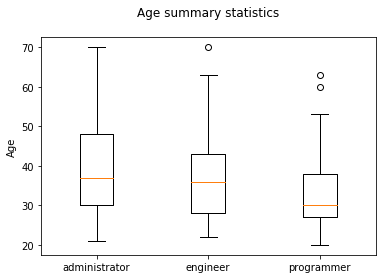

In [74]:
 # Box plots of the ages by profession
boxPlotAges = [adminAges, engAges, progAges]
boxPlotLabels = ['administrator','engineer','programmer' ]
x = np.arange(len(boxPlotLabels))
plt.figure()
plt.boxplot(boxPlotAges)
plt.title('Age summary statistics\n')
plt.ylabel("Age")
plt.xticks(x + 1, boxPlotLabels, rotation=0)
plt.show(block=False)

### Vertical bar chart

In [75]:
movieLines = sc.textFile(dataDir + "u.item")
splitMovieLines = movieLines.map(lambda l:l.split("|"))
moviesRDD = splitMovieLines.map(lambda p:Row(id=p[0], title=p[1], releaseDate=p[2],videoReleaseDate=p[3], url=p[4],
             unknown=int(p[5]),action=int(p[6]),adventure=int(p[7]),animation=int(p[8]),childrens=int(p[9]),
             comedy=int(p[10]),crime=int(p[11]),documentary=int(p[12]),drama=int(p[13]),fantasy=int(p[14]),
             filmNoir=int(p[15]),horror=int(p[16]),musical=int(p[17]),mystery=int(p[18]),romance=int(p[19]),
             sciFi=int(p[20]),thriller=int(p[21]),war=int(p[22]),western=int(p[23])))
moviesDF = spark.createDataFrame(moviesRDD)
moviesDF.createOrReplaceTempView("movies")
genreDF = spark.sql(
     'SELECT sum(unknown) as unknown, sum(action) as action,sum(adventure) as adventure,sum(animation) as animation,'
     'sum(childrens) as childrens,sum(comedy) as comedy,sum(crime) as crime,sum(documentary) as documentary,'
     'sum(drama) as drama,sum(fantasy) as fantasy,sum(filmNoir) as filmNoir,sum(horror) as horror,sum(musical)' 
     'as musical,sum(mystery) as mystery,sum(romance) as romance,sum(sciFi) as sciFi,sum(thriller) as '
     'thriller,sum(war) as war,sum(western) as western FROM movies')

genreList = genreDF.collect()
genreDict = genreList[0].asDict()
labelValues = list(genreDict.keys())
countList = list(genreDict.values())

genreDict

{'unknown': 2,
 'action': 251,
 'adventure': 135,
 'animation': 42,
 'childrens': 122,
 'comedy': 505,
 'crime': 109,
 'documentary': 50,
 'drama': 725,
 'fantasy': 22,
 'filmNoir': 24,
 'horror': 92,
 'musical': 56,
 'mystery': 61,
 'romance': 247,
 'sciFi': 101,
 'thriller': 251,
 'war': 71,
 'western': 27}

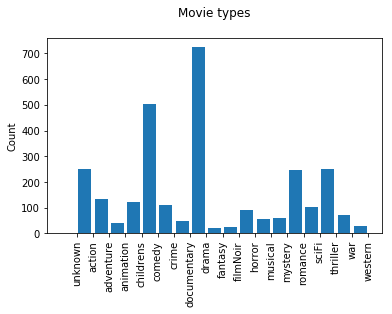

In [76]:
# Movie types and the counts
x = np.arange(len(labelValues))
plt.title('Movie types\n')
plt.ylabel("Count")
plt.bar(x, countList)
plt.xticks(x + 0.5, labelValues,rotation=90)
plt.gcf().subplots_adjust(bottom=0.20)
plt.show(block=False)

### Scatter plot

In [77]:
yearDF = spark.sql(
    'SELECT substring(releaseDate,8,4) as releaseYear, count(*) as movieCount FROM movies GROUP BY substring(releaseDate,8,4) '
    'ORDER BY movieCount DESC LIMIT 10')
yearDF.show()

+-----------+----------+
|releaseYear|movieCount|
+-----------+----------+
|       1996|       355|
|       1997|       286|
|       1995|       219|
|       1994|       214|
|       1993|       126|
|       1998|        65|
|       1992|        37|
|       1990|        24|
|       1991|        22|
|       1989|        15|
+-----------+----------+



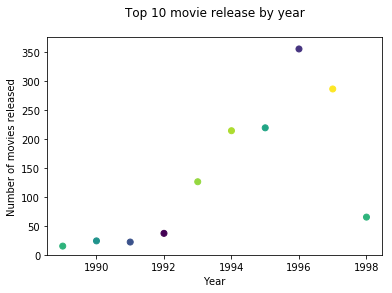

In [78]:
yearMovieCountTuple = yearDF.rdd.map(lambda p:(int(p.releaseYear),p.movieCount)).collect()
yearList,movieCountList = zip(*yearMovieCountTuple)
countArea = yearDF.rdd.map(lambda p: np.pi* (p.movieCount/15)**2).collect()
plt.title('Top 10 movie release by year\n')
plt.xlabel("Year")
plt.ylabel("Number of movies released")
plt.ylim([0,max(movieCountList) + 20])
colors = np.random.rand(10)
plt.scatter(yearList,movieCountList,c=colors)
plt.show(block=False)

### Enhanced Scatter Plot

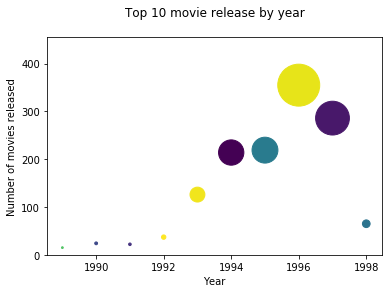

In [79]:
 # Top 10 years where the most number of movies have been released
plt.title('Top 10 movie release by year\n')
plt.xlabel("Year")
plt.ylabel("Number of movies released")
plt.ylim([0,max(movieCountList) + 100])
colors = np.random.rand(10)
plt.scatter(yearList, movieCountList,c=colors,s=countArea)
plt.show(block=False)

### Line Graph

In [80]:
yearActionDF = spark.sql(
    'SELECT substring(releaseDate,8,4) as actionReleaseYear,count(*) as actionMovieCount FROM movies WHERE action = 1 '
    'GROUP BY substring(releaseDate,8,4) ORDER BY actionReleaseYear DESC LIMIT 10')
yearActionDF.show()

+-----------------+----------------+
|actionReleaseYear|actionMovieCount|
+-----------------+----------------+
|             1998|              12|
|             1997|              46|
|             1996|              44|
|             1995|              40|
|             1994|              30|
|             1993|              20|
|             1992|               8|
|             1991|               2|
|             1990|               7|
|             1989|               6|
+-----------------+----------------+



In [81]:
yearActionDF.createOrReplaceTempView("action")
yearDramaDF = spark.sql(
                'SELECT substring(releaseDate,8,4) as dramaReleaseYear,count(*) as dramaMovieCount FROM movies '
                'WHERE drama = 1 GROUP BY substring(releaseDate,8,4) ORDER BY dramaReleaseYear DESC LIMIT 10')
yearDramaDF.show()

+----------------+---------------+
|dramaReleaseYear|dramaMovieCount|
+----------------+---------------+
|            1998|             33|
|            1997|            113|
|            1996|            170|
|            1995|             89|
|            1994|             97|
|            1993|             64|
|            1992|             14|
|            1991|             11|
|            1990|             12|
|            1989|              8|
+----------------+---------------+



In [82]:
yearDramaDF.createOrReplaceTempView("drama")
yearCombinedDF = spark.sql(
    'SELECT a.actionReleaseYear as releaseYear,a.actionMovieCount, d.dramaMovieCount FROM action a, '
    'drama d WHERE a.actionReleaseYear = d.dramaReleaseYear ORDER BY a.actionReleaseYear DESC LIMIT 10 ')
yearCombinedDF.show()

+-----------+----------------+---------------+
|releaseYear|actionMovieCount|dramaMovieCount|
+-----------+----------------+---------------+
|       1998|              12|             33|
|       1997|              46|            113|
|       1996|              44|            170|
|       1995|              40|             89|
|       1994|              30|             97|
|       1993|              20|             64|
|       1992|               8|             14|
|       1991|               2|             11|
|       1990|               7|             12|
|       1989|               6|              8|
+-----------+----------------+---------------+



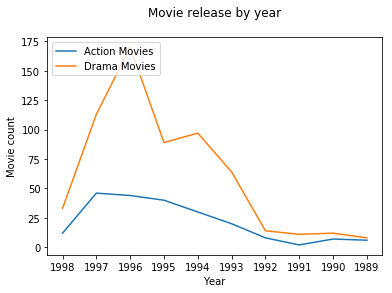

In [83]:
yearMovieCountTuple = yearCombinedDF.rdd.map(lambda p:(p.releaseYear,p.actionMovieCount,p.dramaMovieCount)).collect()
yearList,actionMovieCountList,dramaMovieCountList = zip(*yearMovieCountTuple)
plt.title("Movie release by year\n")
plt.xlabel("Year")
plt.ylabel("Movie count")
line_action, = plt.plot(yearList,actionMovieCountList)
line_drama, = plt.plot(yearList,dramaMovieCountList)
plt.legend([line_action, line_drama], ['Action Movies', 'Drama Movies'],loc='upper left')
#plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show(block=False)

### Why Spark for machine learning?

In [84]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.param import Param, Params
from pyspark.sql import Row
# TODO - Change this directory to the right location where the data is stored
dataDir = "/home/thiamhuat/data/winequality/"
# Create the the RDD by reading the wine data from the disk

#lines = sc.textFile(dataDir + "winequality-red.csv")

lines = sc.textFile(dataDir + "winequality-red.csv")
header = lines.first() 
header = sc.parallelize([header])
lines = lines.subtract(header)

splitLines = lines.map(lambda l:l.split(","))
print(splitLines)
# Vector is a data type with 0 based indices and double-typed values. In that there are two types namely dense and sparse.
# A dense vector is backed by a double array representing its entry values
# A sparse vector is backed by two parallel arrays: indices and values

wineDataRDD = splitLines.map(lambda p: (float(p[11]), Vectors.dense([float(p[0]), float(p[1]), float(p[2]), float(p[3]),
                                                                     float(p[4]), float(p[5]), float(p[6]), float(p[7]), 
                                                                     float(p[8]), float(p[9]), float(p[10])])))

#usersRDD = splitLines.map(lambda p: Row(id=p[0],age=int(p[1]), gender=p[2], occupation=p[3],zipcode=p[4]))

# Create the data frame containing the training data having two columns. 
# 1) The actula output or label of the data 
# 2) The vector containing the features
trainingDF = spark.createDataFrame(wineDataRDD, ['label','features'])
trainingDF.show()

PythonRDD[566] at RDD at PythonRDD.scala:52
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|[7.4,0.7,0.0,1.9,...|
|  5.0|[7.4,0.7,0.0,1.9,...|
|  5.0|[7.8,0.76,0.04,2....|
|  6.0|[11.2,0.28,0.56,1...|
|  7.0|[7.3,0.65,0.0,1.2...|
|  7.0|[7.8,0.58,0.02,2....|
|  5.0|[8.1,0.56,0.28,1....|
|  6.0|[8.9,0.22,0.48,1....|
|  5.0|[7.6,0.39,0.31,2....|
|  5.0|[7.6,0.41,0.24,1....|
|  6.0|[7.8,0.645,0.0,2....|
|  6.0|[6.9,0.685,0.0,2....|
|  5.0|[7.3,0.45,0.36,5....|
|  5.0|[7.3,0.45,0.36,5....|
|  4.0|[4.6,0.52,0.15,2....|
|  6.0|[6.6,0.52,0.04,2....|
|  5.0|[7.8,0.59,0.18,2....|
|  6.0|[7.3,0.39,0.31,2....|
|  5.0|[7.0,0.735,0.05,2...|
|  5.0|[7.2,0.725,0.05,4...|
+-----+--------------------+
only showing top 20 rows



In [85]:
# Create the object of the algorithm which is the Linear Regression with the parameters
# Linear regression parameter to make lr.fit() use at most 10 iterations
lr = LinearRegression(maxIter=10)
# Create a trained model by fitting the parameters using the training data
model = lr.fit(trainingDF)
# Once the model is prepared, to test the model, prepare the test data containing the labels and feature vectors
testDF = spark.createDataFrame([(5.0, Vectors.dense([7.4, 0.7, 0.0, 1.9, 0.076, 25.0, 67.0,
                                                     0.9968, 3.2, 0.68,9.8])),(5.0,Vectors.dense([7.8,
                                                     0.88, 0.0, 2.6, 0.098, 11.0, 34.0, 0.9978, 3.51, 0.56,
                                                     9.4])),(7.0, Vectors.dense([7.3, 0.65, 0.0, 1.2,
                                                     0.065, 15.0, 18.0, 0.9968, 3.36, 0.57, 9.5]))],
                                                     ["label", "features"])
testDF.createOrReplaceTempView("test")
testDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|[7.4,0.7,0.0,1.9,...|
|  5.0|[7.8,0.88,0.0,2.6...|
|  7.0|[7.3,0.65,0.0,1.2...|
+-----+--------------------+



In [86]:
# Do the transformation of the test data using the model and predict the output values or lables.
# This is to compare the predicted value and the actual label value
testTransform = model.transform(testDF)
tested = testTransform.select("features","label", "prediction")
tested.show()

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[7.4,0.7,0.0,1.9,...|  5.0|5.352730835918894|
|[7.8,0.88,0.0,2.6...|  5.0|4.817999362001412|
|[7.3,0.65,0.0,1.2...|  7.0| 5.28010635566897|
+--------------------+-----+-----------------+



In [87]:
# Prepare a dataset without the output/lables to predict the output using the trained model
predictDF = spark.sql("SELECT features FROM test")
predictDF.show()

+--------------------+
|            features|
+--------------------+
|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|
|[7.3,0.65,0.0,1.2...|
+--------------------+



In [88]:
# Do the transformation with the predict dataset and display the predictions
predictTransform = model.transform(predictDF)
predicted = predictTransform.select("features", "prediction")
predicted.show()

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[7.4,0.7,0.0,1.9,...|5.352730835918894|
|[7.8,0.88,0.0,2.6...|4.817999362001412|
|[7.3,0.65,0.0,1.2...| 5.28010635566897|
+--------------------+-----------------+



### Wine Classification

In [89]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param,Params
from pyspark.sql import Row
# TODO - Change this directory to the right location where the data is stored
dataDir = "/home/thiamhuat/data/winequality/"
# Create the the RDD by reading the wine data from the disk
lines = sc.textFile(dataDir + "winequality-white.csv")

header = lines.first() 
header = sc.parallelize([header])
lines = lines.subtract(header)

splitLines = lines.map(lambda l:l.split(";"))
wineDataRDD = splitLines.map(lambda p:(float(0) if (float(p[11]) < 7) else float(1),
                           Vectors.dense([float(p[0]), float(p[1]), float(p[2]),
                             float(p[3]), float(p[4]), float(p[5]), float(p[6]),
                             float(p[7]), float(p[8]), float(p[9]), float(p[10])])))
# Create the data frame containing the training data having two columns. 
# 1) The actula output or label of the data 
# 2) The vector containing the features
trainingDF = spark.createDataFrame(wineDataRDD, ['label','features'])
trainingDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[8.1,0.27,0.41,1....|
|  0.0|[8.6,0.23,0.4,4.2...|
|  0.0|[7.9,0.18,0.37,1....|
|  0.0|[7.0,0.25,0.32,9....|
|  1.0|[7.2,0.32,0.36,2....|
|  0.0|[5.8,0.27,0.2,14....|
|  0.0|[6.5,0.39,0.23,5....|
|  0.0|[7.0,0.33,0.32,1....|
|  0.0|[6.7,0.24,0.39,2....|
|  0.0|[6.6,0.24,0.27,1....|
|  0.0|[6.7,0.23,0.26,1....|
|  0.0|[7.2,0.21,0.34,11...|
|  0.0|[6.0,0.19,0.26,12...|
|  0.0|[6.0,0.19,0.26,12...|
|  0.0|[7.0,0.47,0.07,1....|
|  0.0|[7.2,0.24,0.27,1....|
|  1.0|[6.7,0.23,0.31,2....|
|  1.0|[6.7,0.23,0.31,2....|
|  0.0|[8.6,0.23,0.46,1....|
|  1.0|[7.0,0.32,0.34,1....|
+-----+--------------------+
only showing top 20 rows



In [90]:
# Create the object of the algorithm which is the Logistic Regression with the parameters
# LogisticRegression parameter to make lr.fit() use at most 10 iterations and the regularization parameter.
# When a higher degree polynomial used by the algorithm to fit a set of points in a linear regression model, 
# to prevent overfitting,regularization is used and this parameter is just for that
lr = LogisticRegression(maxIter=10,regParam=0.01)
# Create a trained model by fitting the parameters using the training data
model = lr.fit(trainingDF)
# Once the model is prepared, to test the model, prepare the test data containing the labels and feature vectors
testDF = spark.createDataFrame([(1.0,Vectors.dense([6.1,0.32,0.24,1.5,0.036,43,140,0.9894,3.36,0.64,10.7])),
                                (0.0,Vectors.dense([5.2,0.44,0.04,1.4,0.036,38,124,0.9898,3.29,0.42,12.4])),
                                (0.0,Vectors.dense([7.2,0.32,0.47,5.1,0.044,19,65,0.9951,3.38,0.36,9])),
                                (0.0,Vectors.dense([6.4,0.595,0.14,5.2,0.058,15,97,0.991,3.03,0.41,12.6]))], 
                                ["label", "features"])
testDF.createOrReplaceTempView("test")
testDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[6.1,0.32,0.24,1....|
|  0.0|[5.2,0.44,0.04,1....|
|  0.0|[7.2,0.32,0.47,5....|
|  0.0|[6.4,0.595,0.14,5...|
+-----+--------------------+



In [91]:
# Do the transformation of the test data using the model and predict the output values or lables. 
# This is to compare the predicted value and the actual label value
testTransform = model.transform(testDF)
tested = testTransform.select("features","label", "prediction")
tested.show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[6.1,0.32,0.24,1....|  1.0|       0.0|
|[5.2,0.44,0.04,1....|  0.0|       0.0|
|[7.2,0.32,0.47,5....|  0.0|       0.0|
|[6.4,0.595,0.14,5...|  0.0|       0.0|
+--------------------+-----+----------+



In [92]:
# Prepare a dataset without the output/lables to predict the output using the trained model
predictDF = spark.sql("SELECT features FROM test")
predictDF.show()

+--------------------+
|            features|
+--------------------+
|[6.1,0.32,0.24,1....|
|[5.2,0.44,0.04,1....|
|[7.2,0.32,0.47,5....|
|[6.4,0.595,0.14,5...|
+--------------------+



In [93]:
# Do the transformation with the predict dataset and display the predictions
predictTransform = model.transform(predictDF)
predicted = testTransform.select("features", "prediction")
predicted.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[6.1,0.32,0.24,1....|       0.0|
|[5.2,0.44,0.04,1....|       0.0|
|[7.2,0.32,0.47,5....|       0.0|
|[6.4,0.595,0.14,5...|       0.0|
+--------------------+----------+



### Spam filtering

In [94]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
# Prepare training documents from a list of messages from emails used to filter them as spam or not spam
# If the original message is a spam then the label is 1 and if the message is genuine then the label is 0
LabeledDocument = Row("email","message", "label")
training = spark.createDataFrame([("you@example.com", "hope you are well", 0.0),
                                  ("raj@example.com", "nice to hear from you", 0.0),
                                  ("thomas@example.com", "happy holidays",0.0),
                                  ("mark@example.com", "see you tomorrow", 0.0),
                                  ("xyz@example.com", "save money", 1.0),
                                  ("top10@example.com", "low interest rate", 1.0),
                                  ("marketing@example.com", "cheap loan", 1.0)],
                                 ["email", "message", "label"])
training.show()

+--------------------+--------------------+-----+
|               email|             message|label|
+--------------------+--------------------+-----+
|     you@example.com|   hope you are well|  0.0|
|     raj@example.com|nice to hear from...|  0.0|
|  thomas@example.com|      happy holidays|  0.0|
|    mark@example.com|    see you tomorrow|  0.0|
|     xyz@example.com|          save money|  1.0|
|   top10@example.com|   low interest rate|  1.0|
|marketing@example...|          cheap loan|  1.0|
+--------------------+--------------------+-----+



In [95]:
# Configure an Spark machine learning pipeline, consisting of three stages: tokenizer,hashingTF, and lr.
tokenizer = Tokenizer(inputCol="message",outputCol="words")
hashingTF = HashingTF(inputCol="words",outputCol="features")
# LogisticRegression parameter to make lr.fit() use at most 10 iterations and the regularization parameter.
# When a higher degree polynomial used by the algorithm to fit a set of points in a linear regression model, 
# to prevent overfitting, regularization is used and this parameter is just for that
lr = LogisticRegression(maxIter=10,regParam=0.01)
pipeline = Pipeline(stages=[tokenizer,hashingTF, lr])
# Fit the pipeline to train the model to study the messages
model = pipeline.fit(training)
# Prepare messages for prediction, which are not categorized and leaving upto the algorithm to predict
test = spark.createDataFrame([("you@example.com", "how are you"),
                              ("jain@example.com", "hope doing well"),
                              ("caren@example.com", "want some money"),
                              ("zhou@example.com", "secure loan"),
                              ("ted@example.com","need loan")], ["email","message"])
test.show()

+-----------------+---------------+
|            email|        message|
+-----------------+---------------+
|  you@example.com|    how are you|
| jain@example.com|hope doing well|
|caren@example.com|want some money|
| zhou@example.com|    secure loan|
|  ted@example.com|      need loan|
+-----------------+---------------+



In [96]:
# Make predictions on the new messages
prediction = model.transform(test).select("email", "message","prediction")
prediction.show()

+-----------------+---------------+----------+
|            email|        message|prediction|
+-----------------+---------------+----------+
|  you@example.com|    how are you|       0.0|
| jain@example.com|hope doing well|       0.0|
|caren@example.com|want some money|       1.0|
| zhou@example.com|    secure loan|       1.0|
|  ted@example.com|      need loan|       1.0|
+-----------------+---------------+----------+



In [97]:
wordsDF = tokenizer.transform(training)
wordsDF.createOrReplaceTempView("word")
selectedFieldstDF = spark.sql("SELECT message, words FROM word")
selectedFieldstDF.show()

+--------------------+--------------------+
|             message|               words|
+--------------------+--------------------+
|   hope you are well|[hope, you, are, ...|
|nice to hear from...|[nice, to, hear, ...|
|      happy holidays|   [happy, holidays]|
|    see you tomorrow|[see, you, tomorrow]|
|          save money|       [save, money]|
|   low interest rate|[low, interest, r...|
|          cheap loan|       [cheap, loan]|
+--------------------+--------------------+



In [98]:
featurizedDF = hashingTF.transform(wordsDF)
featurizedDF.createOrReplaceTempView("featurized")
selectedFeaturizedFieldstDF = spark.sql("SELECT words, features FROM featurized")
selectedFeaturizedFieldstDF.show()

+--------------------+--------------------+
|               words|            features|
+--------------------+--------------------+
|[hope, you, are, ...|(262144,[128160,1...|
|[nice, to, hear, ...|(262144,[22346,10...|
|   [happy, holidays]|(262144,[86293,23...|
|[see, you, tomorrow]|(262144,[29129,21...|
|       [save, money]|(262144,[199496,2...|
|[low, interest, r...|(262144,[68685,13...|
|       [cheap, loan]|(262144,[12946,16...|
+--------------------+--------------------+



### Finding synonyms

In [ ]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql import Row
# TODO - Change this directory to the right location where the data is stored
dataDir = "/home/thiamhuat/data/20_newsgroups/*"
# Read the entire text into a DataFrame
textRDD = sc.wholeTextFiles(dataDir).map(lambda recs: Row(sentence=recs[1]))
textDF = spark.createDataFrame(textRDD)
# Tokenize the sentences to words
regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="words",gaps=False, pattern="\\w+")
tokenizedDF = regexTokenizer.transform(textDF)
# Prepare the Estimator It sets the vector size, and the parameter minCount sets the minimum number of times a
# token must appear to be included in the word2vec model's vocabulary.
word2Vec = Word2Vec(vectorSize=3,minCount=0, inputCol="words", outputCol="result")
# Train the model
model = word2Vec.fit(tokenizedDF)
# Find 10 synonyms of a given word
synonyms1 = model.findSynonyms("gun",10)
synonyms1.show()

In [ ]:
# Find 10 synonyms of a different word
synonyms2 = model.findSynonyms("crime",10)
synonyms2.show()